In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [ ]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
875764,4,1680849729,Sat May 02 12:38:22 PDT 2009,NO_QUERY,hey2020,@mileycyrus Hey Miley I hope ur having a decen...
699667,0,2254518687,Sat Jun 20 09:52:27 PDT 2009,NO_QUERY,xVictorx408,Just wole up. I hate waking up early
1067301,4,1965468005,Fri May 29 15:58:32 PDT 2009,NO_QUERY,kotterpin55,@glennbeck Excited to see YOU and you're NOT o...
64119,0,1687931737,Sun May 03 09:56:33 PDT 2009,NO_QUERY,b3xy,stupid computer why wont you play any cds
1248516,4,1995851703,Mon Jun 01 14:08:48 PDT 2009,NO_QUERY,dylanwolf,@jarsofclay Just opened it up. First reaction:...


In [ ]:
df.target.value_counts()

0    800000
4    800000
Name: target, dtype: int64

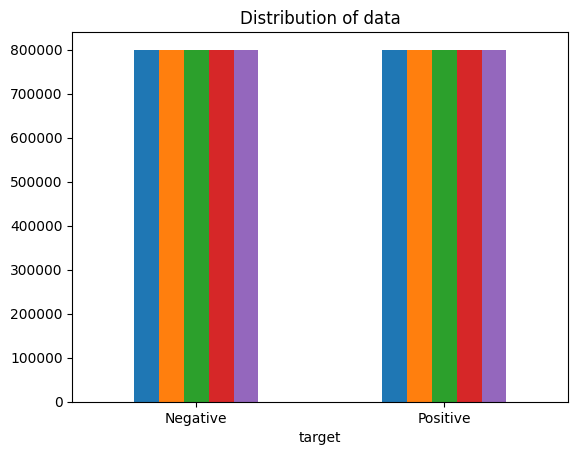

In [ ]:
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
text, sentiment = list(df['text']), list(df['target'])

In [ ]:
data=df[['text','target']]
data['target'] = data['target'].replace(4,1)
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]
data_pos = data_pos.iloc[:int(100000)]
data_neg = data_neg.iloc[:int(100000)]
dataset = pd.concat([data_pos, data_neg])
dataset['text']=dataset['text'].str.lower()
dataset['text'].sample(5)

<ipython-input-6-deafdaad4382>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


882369    i'm hungry ? ... think that i'm going to make ...
843105    @stasia19 wanna be a good friend &amp; transla...
886107    hi @halelrod tks and look forward to reading y...
862794                              yupee!! we're creepy!! 
855576        @eatlikeagirl 17 types!!!!! wow - impressed. 
Name: text, dtype: object

In [ ]:
text=dataset['text']
target=dataset['target']
x_train, x_test, y_train, y_test = train_test_split(text,target,test_size=0.1,random_state=0,stratify=target)

In [ ]:
max_features = 5000

maxlen = 30
batch_size = 32


tokenizer=Tokenizer(max_features,oov_token="<?>")
tokenizer.fit_on_texts(x_train)
X_train=tokenizer.texts_to_sequences(x_train)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_test=tokenizer.texts_to_sequences(x_test)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x text length)')
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Found 139937 unique tokens.
180000 train sequences
20000 test sequences
Pad sequences (samples x text length)
X_train shape: (180000, 30)
X_test shape: (20000, 30)


In [ ]:
glove_dir = '/content/drive/MyDrive/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 100 

embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_features:
        if embedding_vector is not None:

            embedding_matrix[i] = embedding_vector

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(layers.Bidirectional(layers.LSTM(64,dropout=0.3,recurrent_dropout=0.3,return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(32,dropout=0.5,recurrent_dropout=0.5)))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           500000    
                                                                 
 bidirectional (Bidirectiona  (None, 30, 128)          84480     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 626,753
Trainable params: 126,753
Non-trai

In [ ]:
tokenizer.save('token.h5')

AttributeError: ignored

In [ ]:
Earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test),
                    callbacks = [Earlystop])

Epoch 1/30
5625/5625 [==============================] - 832s 146ms/step - loss: 0.5404 - accuracy: 0.7265 - val_loss: 0.4846 - val_accuracy: 0.7696
Epoch 2/30
5625/5625 [==============================] - 803s 143ms/step - loss: 0.4879 - accuracy: 0.7638 - val_loss: 0.4615 - val_accuracy: 0.7847
Epoch 3/30
5625/5625 [==============================] - 797s 142ms/step - loss: 0.4701 - accuracy: 0.7752 - val_loss: 0.4598 - val_accuracy: 0.7875
Epoch 4/30
5625/5625 [==============================] - 776s 138ms/step - loss: 0.4592 - accuracy: 0.7828 - val_loss: 0.4454 - val_accuracy: 0.7929
Epoch 5/30
5625/5625 [==============================] - 768s 137ms/step - loss: 0.4516 - accuracy: 0.7868 - val_loss: 0.4406 - val_accuracy: 0.7935
Epoch 6/30
5625/5625 [==============================] - 801s 142ms/step - loss: 0.4451 - accuracy: 0.7908 - val_loss: 0.4474 - val_accuracy: 0.7921
Epoch 7/30
5625/5625 [==============================] - 803s 143ms/step - loss: 0.4400 - accuracy: 0.7941 - val_

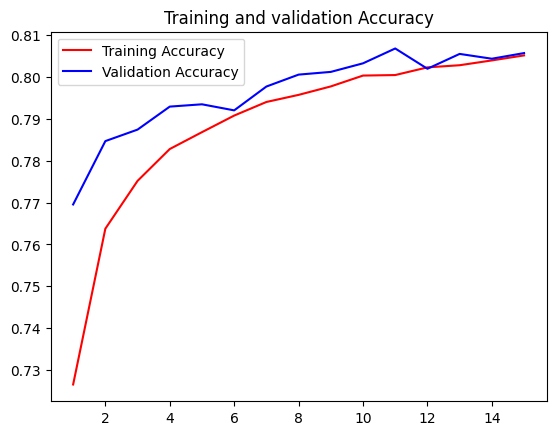

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1,16)

plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()

plt.show()

In [ ]:
import pickle

# saving
with open('contents/drive/MyDrive/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
#with open('tokenizer.pickle', 'rb') as handle:
 #   tokenizer = pickle.load(handle)


In [ ]:
model.save('contents/drive/MyDrive/twitter_sentiment.h5')